# Data Load

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages and set up random seed

In [145]:
import torch
import numpy as np
import random
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import gc

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

In [ ]:
seed = 42
set_seed(seed) #ensure repeated work

# Set up torch transformer

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #apply for the very ugly colour allocation - not normally
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #as pre-train used found from torch wbesite
])

In [149]:
data_dir = '/content/drive/MyDrive/image_class_task_dataset'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Prepare For Training used fucntion here

In [ ]:
def calculate_class_weights(dataset):
    # initilize amount
    num_classes = len(set(dataset.targets))
    class_counts = [0] * num_classes

    # count label
    for label in dataset.targets:
        class_counts[label] += 1

    # weight count for label amount think about later use for label imbalance test. 
    weights = [1.0 / count if count > 0 else 0.0 for count in class_counts]
    class_weights = torch.tensor(weights, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()  # normalization

    return class_weights

In [151]:
# define model
def initialize_model(model_type, num_classes, use_dropout):
    """set up model for different types"""
    if model_type == 'resnet':
        model = models.resnet18(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

    elif model_type == 'mobilenet':
        model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

    elif model_type == 'alexnet':
        model = models.alexnet(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes)) if use_dropout else nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # forzen all layers
    for param in model.parameters():
        param.requires_grad = False

    # unforzen classifier layer
    if model_type == 'resnet':
        for param in model.fc.parameters():
            param.requires_grad = True
    elif model_type == 'mobilenet':
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif model_type == 'alexnet':
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    return model.to(device)

In [ ]:
def train_and_validate(model, criterion, optimizer, train_loader, valid_loader, scheduler=None,
                       num_epochs=50, grad_clip=None, device='cpu'):

    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # gradient clipping apply here search from online useful optimizer methods
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # average loss and acc per whole dataset record see the change not per batch
        train_loss = running_loss / total_train
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # start val step from here
        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)

        # as above
        valid_loss /= total_valid
        valid_acc = 100 * correct_valid / total_valid
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        # print current progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_acc:.2f}%")

        # change lr if have
        if scheduler:
            scheduler.step(valid_loss if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau) else None)

    return history

# Set up experimental 1 batch size lr and optimizer for res-18

In [ ]:
# define parameter
batch_size_options = [16, 32]
learning_rates_dict = {'SGD': [1e-3, 5e-3],    # SGD search from online said suitable value
             'Adam': [1e-3, 5e-3]}    # Adam as above
model_types = ['resnet', 'mobilenet', 'alexnet']
optimizers = ['SGD', 'Adam']

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [155]:
experiment_results_1 = []

In [13]:
# # definf parameter
# batch_size_options = [8, 16, 32]
# learning_rates = [1e-4, 5e-5, 1e-5]
# model_types = ['resnet', 'mobilenet', 'alexnet']
# optimizers = ['SGD', 'Adam']  # optimizer type
# weight_decay_options = [0.0, 5e-4]  # Weight decay
# schedulers = ['None', 'CosineAnnealingLR', 'ReduceLROnPlateau']
# grad_clips = [None, 1.0]  # clip grandient or not
# use_class_weights_options = [True, False]  # use class weights or not for label imbalance
# use_dropout_options = [True, False]  # use or not user Dropout

# Experiment 1 Starting From Here

In [ ]:
for model_type in model_types:
    for batch_size in batch_size_options:

        # set up loafer
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

        num_classes = len(train_loader.dataset.classes)

        for optimizer_type in optimizers:

            # lr
            learning_rates = learning_rates_dict[optimizer_type]

            for lr in learning_rates:
                # realease ram found run slower if not release
                torch.cuda.empty_cache()
                gc.collect()

                # set seed ensure repeated resu;t
                set_seed(42)

                # initlize model
                model = initialize_model(model_type, num_classes, use_dropout=False).to(device)

                # define loss function
                criterion = nn.CrossEntropyLoss()

                # define optimizer
                if optimizer_type == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif optimizer_type == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                # print settings
                print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={lr}, Optimizer={optimizer_type}\n")

                # train and eval
                history = train_and_validate(
                    model, criterion, optimizer, train_loader, valid_loader,
                    scheduler=None, num_epochs=100, grad_clip=None, device=device
                )

                # recod result
                experiment_results_1.append({
                    'model_type': model_type,
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'optimizer_type': optimizer_type,
                    'history': history
                })


Training resnet with Batch Size=16, LR=0.001, Optimizer=SGD

Epoch [1/100], Train Loss: 1.3883, Train Acc: 27.46%, Valid Loss: 1.2767, Valid Acc: 48.78%
Epoch [2/100], Train Loss: 1.2006, Train Acc: 52.82%, Valid Loss: 1.2235, Valid Acc: 58.54%
Epoch [3/100], Train Loss: 1.0969, Train Acc: 57.75%, Valid Loss: 0.9509, Valid Acc: 78.05%
Epoch [4/100], Train Loss: 0.9350, Train Acc: 60.56%, Valid Loss: 0.7964, Valid Acc: 68.29%
Epoch [5/100], Train Loss: 0.8936, Train Acc: 62.68%, Valid Loss: 0.8139, Valid Acc: 73.17%
Epoch [6/100], Train Loss: 0.8426, Train Acc: 66.20%, Valid Loss: 0.6540, Valid Acc: 73.17%
Epoch [7/100], Train Loss: 0.7268, Train Acc: 74.65%, Valid Loss: 0.7546, Valid Acc: 73.17%
Epoch [8/100], Train Loss: 0.7050, Train Acc: 70.42%, Valid Loss: 0.6303, Valid Acc: 80.49%
Epoch [9/100], Train Loss: 0.6525, Train Acc: 76.76%, Valid Loss: 0.6397, Valid Acc: 78.05%
Epoch [10/100], Train Loss: 0.5783, Train Acc: 78.17%, Valid Loss: 0.5558, Valid Acc: 82.93%
Epoch [11/100], T

# Save E1 result

In [157]:
import pandas as pd

In [158]:
experiment_df = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_1
])

In [ ]:
# not expand per epch result use per settings info
experiment_df.to_csv("experiment_results.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


# Visulize result for E1

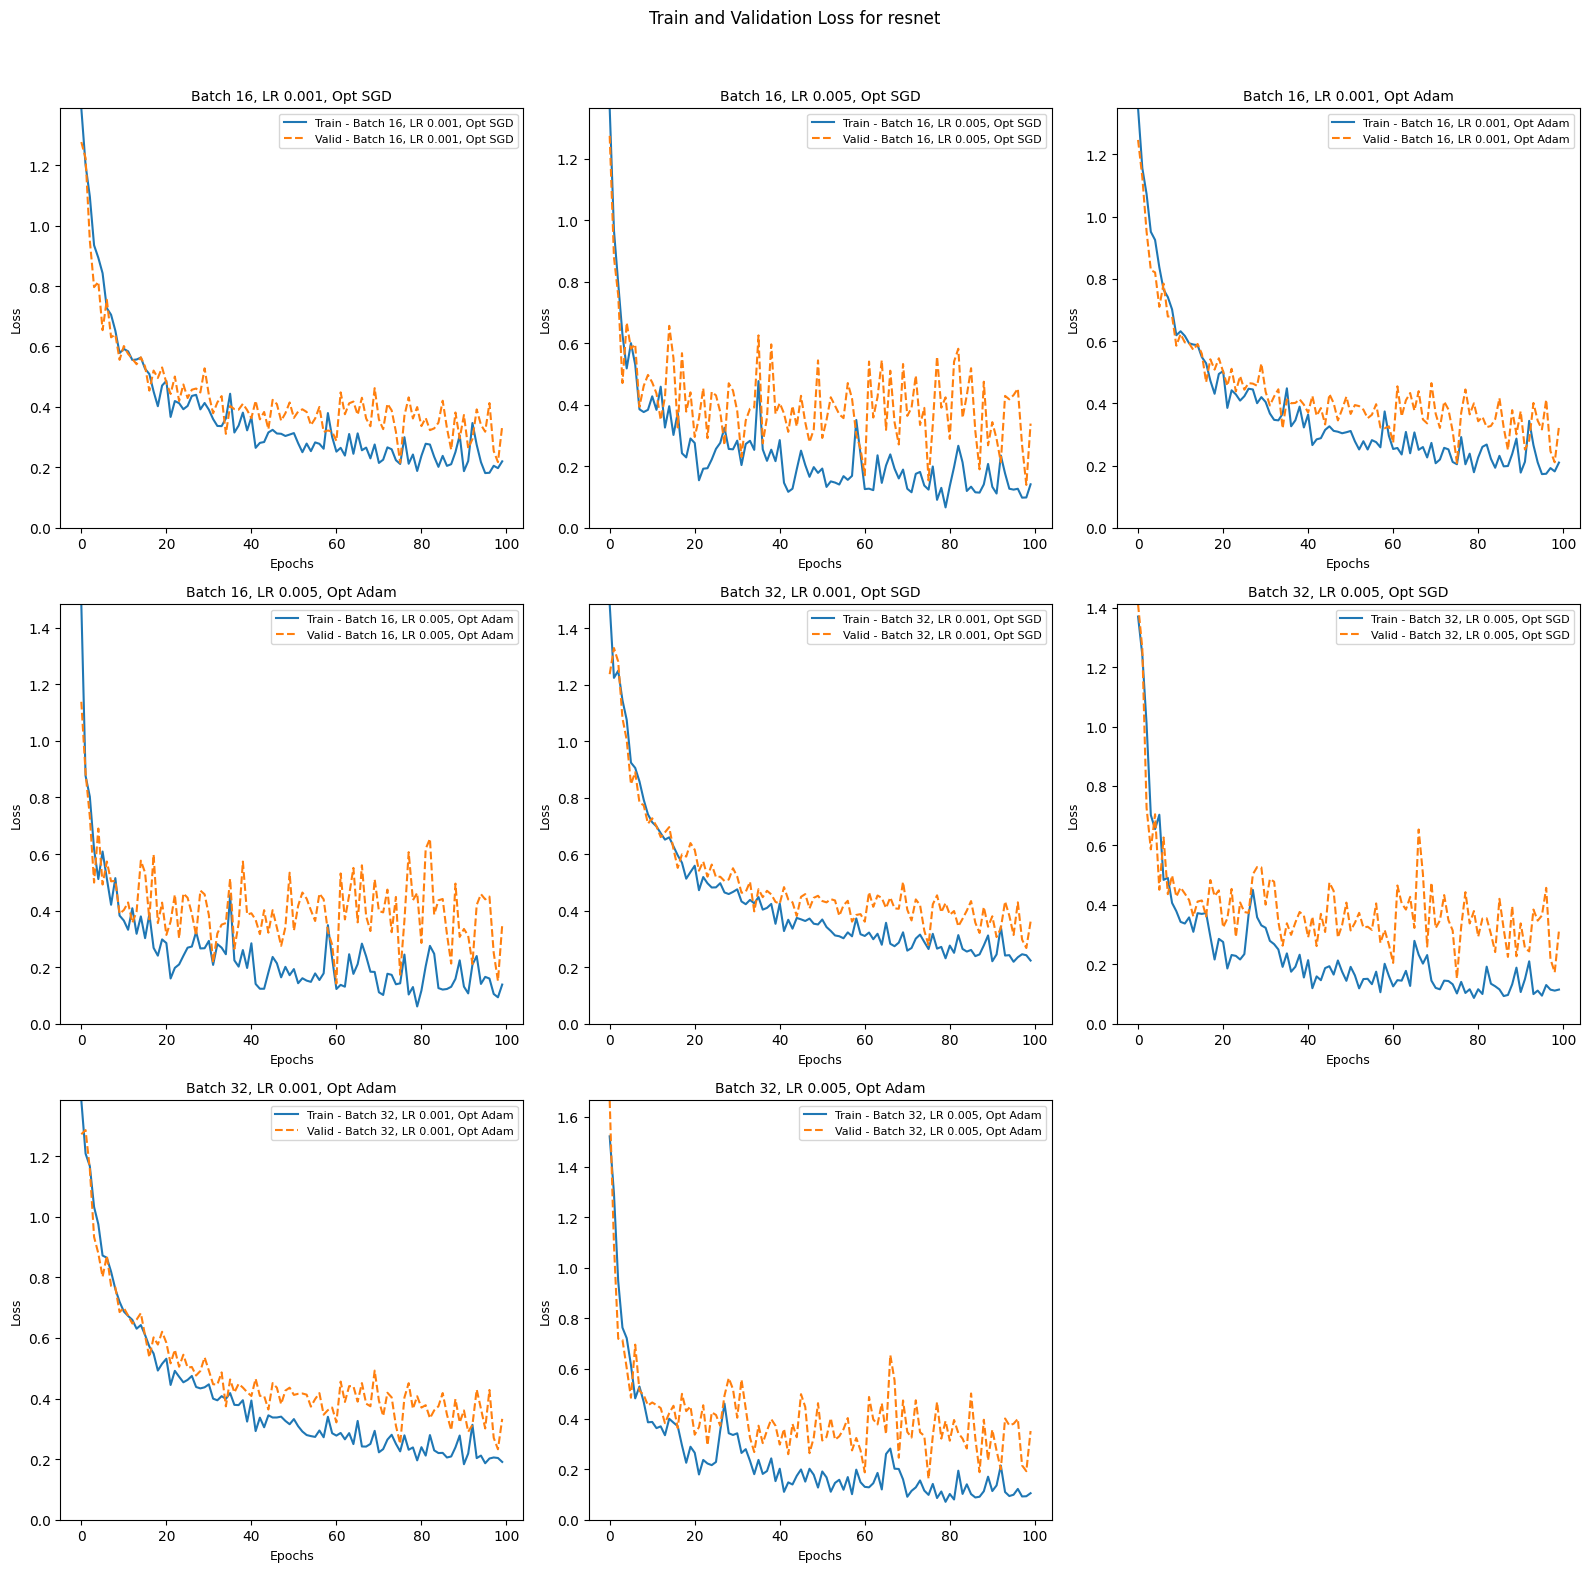

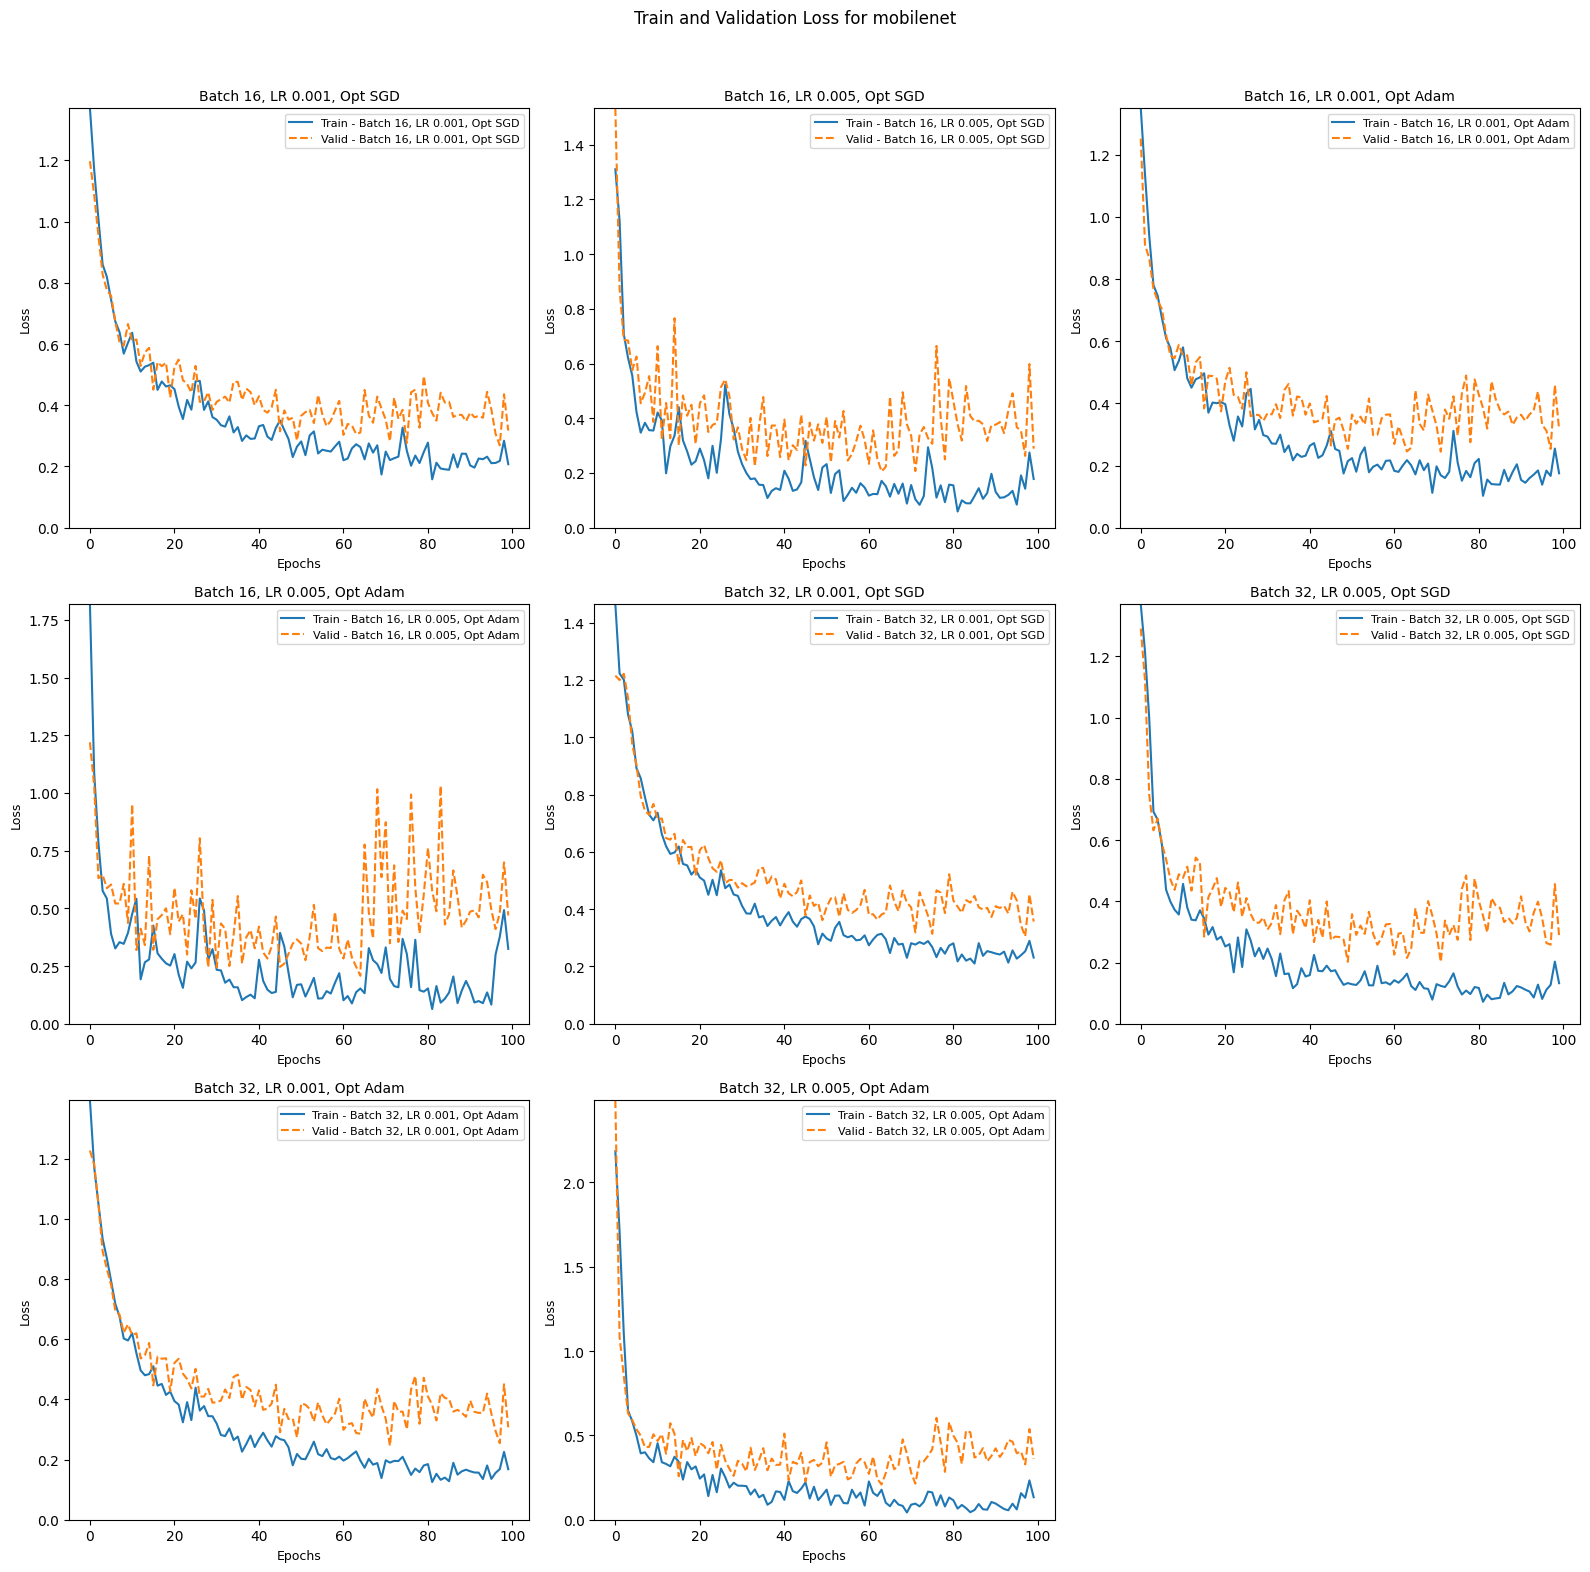

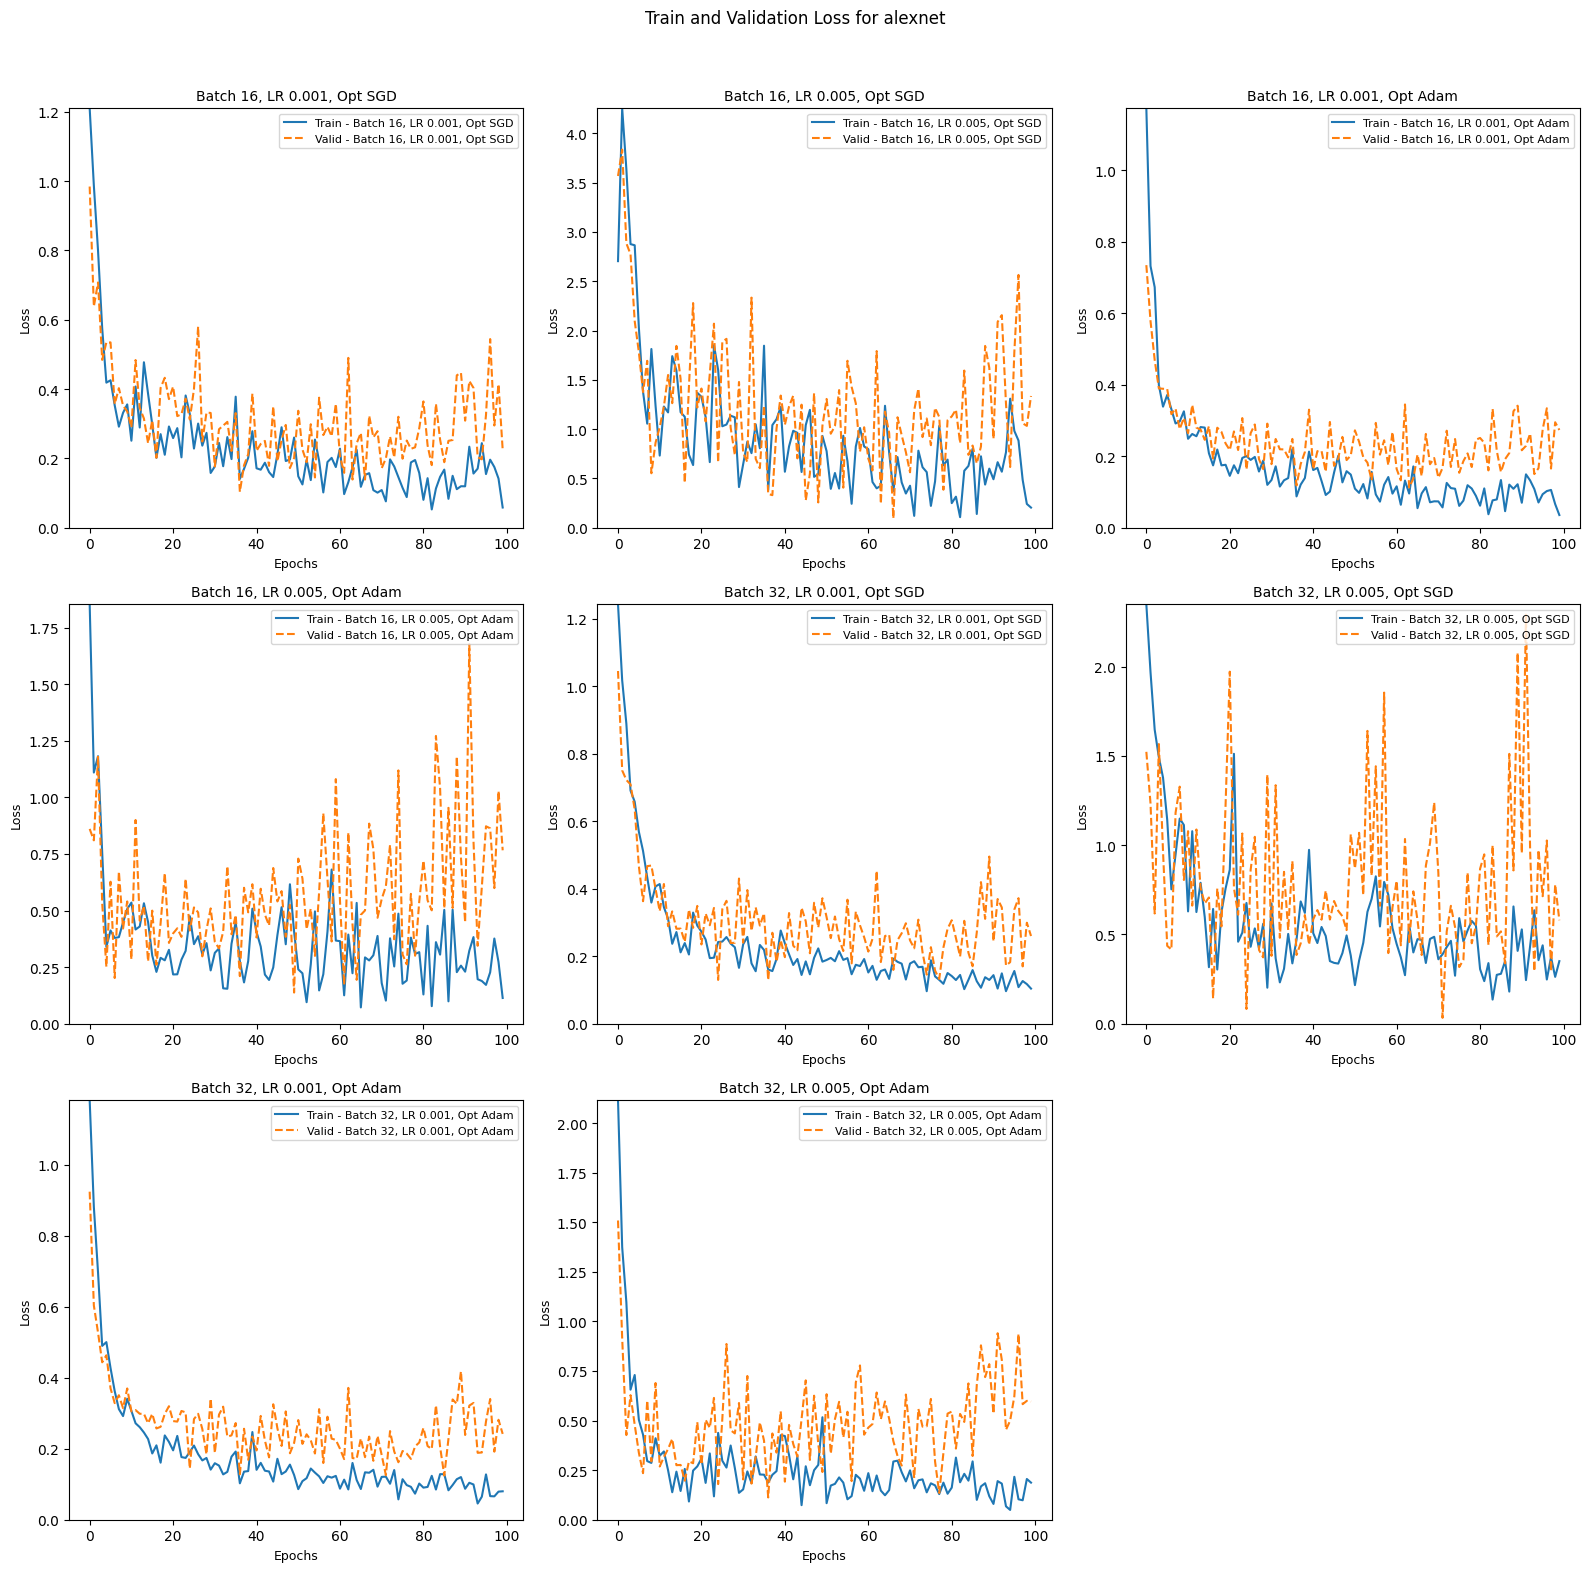

In [ ]:
rows, cols = 3, 3

def plot_combined_loss(model_name, results):
    
    model_results = [result for result in results if result['model_type'] == model_name]

    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    axes = axes.flatten()  # 

    for i, result in enumerate(model_results):
        label = f"Batch {result['batch_size']}, LR {result['learning_rate']}, Opt {result['optimizer_type']}"
        ax = axes[i]

        train_loss_data = result['history']['train_loss']
        valid_loss_data = result['history']['valid_loss']

        # both train and validation loss on the same subplot
        if train_loss_data and valid_loss_data:  # Ensure data is not empty
            ax.plot(train_loss_data, label=f"Train - {label}")
            ax.plot(valid_loss_data, label=f"Valid - {label}", linestyle="--")
            ax.set_title(label, fontsize=10)
            ax.set_xlabel("Epochs", fontsize=9)
            ax.set_ylabel("Loss", fontsize=9)
            ax.legend(loc='upper right', fontsize=8)

            # Set y-limits adaptively based on the combined min/max of train and valid loss
            combined_min = min(0, 0)
            combined_max = max(max(train_loss_data), max(valid_loss_data))
            ax.set_ylim([combined_min, combined_max])

    # 
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Title and layout adjustments
    plt.suptitle(f"Train and Validation Loss for {model_name}", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot combined train and validation loss for each model
for model_name in ["resnet", "mobilenet", "alexnet"]:
    plot_combined_loss(model_name, experiment_results_1)
